# Sistema Fuzzy para Diagnóstico de Diabetes


## Resumo

Para o desenvolvimento do sistema, foi utilizada uma base de dados que contém informações sobre pacientes para fins de diagnóstico de diabetes, com valores para`colesterol`, `idade`, `imc`, `pressão sistólica e diastólica`, etc. A partir desses dados, foram geradas regras para determinar o diagnóstico. Houve então o processo de fuzzificação, construindo os conjuntos fuzzy para as variáveis, bem como foram definidas as funções de pertinência para cada classe referente as variáveis. Ao final, o sistema recebe dados novos e a partir do engenho de inferências fuzzy, retorna um valor de classificação defuzzificado

![](src/fuzzy_system.png)

In [34]:
# Definição das bibliotecas python utilizada
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import locale

locale.setlocale(locale.LC_ALL, '')
np.random.seed(43)

### Análise e Visualização dos Dados

In [3]:
diabetes2 = pd.read_csv("src/diabetes2.csv", index_col="patient_number")

diabetes2 = diabetes2.drop(columns=["chol_hdl_ratio", "gender", "waist", "hip", "height", "weight"])
diabetes2["diabetes"] = diabetes2["diabetes"].map({"No diabetes": 0, "Diabetes": 1})
diabetes2["bmi"] = diabetes2["bmi"].apply(lambda x: locale.atof(x))
diabetes2.head()

,cholesterol,glucose,hdl_chol,age,bmi,systolic_bp,diastolic_bp,waist_hip_ratio,diabetes
patient_number,,,,,,,,,
1,193,77,49,19,22.5,118,70,"0,84",0
2,146,79,41,19,26.4,108,58,"0,83",0
3,217,75,54,20,29.3,110,72,"0,89",0
4,226,97,70,20,19.6,122,64,"0,79",0
5,164,91,67,20,20.2,122,86,"0,82",0


In [4]:
diabetes2.describe()

,cholesterol,glucose,hdl_chol,age,bmi,systolic_bp,diastolic_bp,diabetes
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,207.230769,107.338462,50.266667,46.774359,28.775641,137.133333,83.289744,0.153846
std,44.666005,53.798188,17.279069,16.435911,6.600915,22.859528,13.498192,0.361265
min,78.000000,48.000000,12.000000,19.000000,15.200000,90.000000,48.000000,0.000000
25%,179.000000,81.000000,38.000000,34.000000,24.100000,122.000000,75.000000,0.000000
50%,203.000000,90.000000,46.000000,44.500000,27.800000,136.000000,82.000000,0.000000
75%,229.000000,107.750000,59.000000,60.000000,32.275000,148.000000,90.000000,0.000000
max,443.000000,385.000000,120.000000,92.000000,55.800000,250.000000,124.000000,1.000000


In [148]:
list(diabetes2.columns)

['cholesterol',
 'glucose',
 'hdl_chol',
 'age',
 'bmi',
 'systolic_bp',
 'diastolic_bp',
 'waist_hip_ratio',
 'diabetes']

### Regras Geradas


1. SE systolic_bp > 140 E glucose > 130 ENTÃO DIABETES
2. SE glucose > 125 E bmi > 30 ENTÃO DIABETES
3. SE glucose entre 100 E 125 E age > 50 ENTÃO PRE_DIABETES
4. SE cholesterol > 200 E hdl_chol < 40 ENTÃO DIABETES
5. SE bmi > 30 E glucose > 126 ENTÃO DIABETES
6. SE glucose <= 99 E bmi <= 25 ENTÃO SEM_DIABETES
7. SE glucose entre 100 E 125 E bmi entre 25 E 30 ENTÃO PRE_DIABETES
8. SE systolic_bp > 140 E diastolic_bp > 90 E glucose > 126 ENTÃO DIABETES
9. SE age > 60 E glucose entre 100 E 125 ENTÃO PRE_DIABETES
10. SE hdl_chol >= 60 E cholesterol <= 200 ENTÃO SEM_DIABETES

### Classificações das Variáveis

Para a classificação a seguir, foram utilizados valores de referência comuns, definidos por instituições médicas

1. P_SISTOLICA
    - < 120, normal(tri)
    - 120-140, elevada (trap)
    - 140+, hipertensão (tri)
2. P_DIASTOLICA
    - < 80, normal (tri)
    - 80-100 elevada (trap)
    - 120+ hipertensão (tri)
3. GLUCOSE
   - < 70, baixa (z)
   - 70 - 99, normal (trap)
   - 100 - 125, alta (trap)
   - 125+, muito alta (s)
4. COLESTEROL
   - < 200, desejável (z)
   - 200-240, limite (gauss)
   - 240+ alto (s)
5. HDL COLESTEROL
   - < 40, baixo (z)
   - 40-60, adequado (gauss)
   - 60+, alto (s)
6. IMC
   - < 18.5, baixo (z)
   - 18.5 - 24.9, normal (trap)
   - 25 - 29.9, sobrepeso (trap)
   - 30+ obeso (s)
6. IDADE
   - 18-24, jovem adulto (z)
   - 25-59 adulto (trap)
   - 60+, idoso (s)

### Construindo o Sistema


O sistema foi construido utilizando a biblioteca **Scikit-Fuzzy**. As variáveis dependentes foram definidas como antecedentes, enquanto a variável independente (resultado), como consequente, para a formação das regras. Os intervalos (universo) utilizados para cada variável seguem os limites minimos e máximos da base de dados

In [15]:
# Definindo as variáveis de Entrada com ScikitFuzzy
systolic_bp = ctrl.Antecedent(np.arange(90, 251, 1), 'systolic_bp')
diastolic_bp = ctrl.Antecedent(np.arange(48, 125, 1), 'diastolic_bp')
glucose = ctrl.Antecedent(np.arange(48, 386, 1), 'glucose')
cholesterol = ctrl.Antecedent(np.arange(78, 444, 1), 'cholesterol')
hdl_chol = ctrl.Antecedent(np.arange(12, 121, 1), 'hdl_chol')
bmi = ctrl.Antecedent(np.arange(15.2, 55.8, 0.1), 'bmi')
age = ctrl.Antecedent(np.arange(19, 92, 1), 'age')

resultado = ctrl.Consequent(np.arange(0, 2.01, 0.02), 'resultado')

#### Funções de Pertiência

As funções de pertinência foram definidas objetivando uma leve interseção entre as classes, para possibilitar um cenário mais real, quanto a subjetividade (inprecisão) da categorização dos intervalos. Diferentes formatos geométricos foram usados para explorar a diversidade das variáveis

![](src/pertinencia.png)

In [ ]:
# Funções de pertinência para pressão sistólica
systolic_bp['normal'] = fuzz.trimf(systolic_bp.universe, [90, 110, 130])
systolic_bp['elevada'] = fuzz.trapmf(systolic_bp.universe, [115, 130, 140, 150])
systolic_bp['hipertensao'] = fuzz.trimf(systolic_bp.universe, [135, 160, 251])

# Funções de pertinência para pressão diastólica
diastolic_bp['normal'] = fuzz.trimf(diastolic_bp.universe, [48, 65, 85])
diastolic_bp['elevada'] = fuzz.trapmf(diastolic_bp.universe, [75, 85, 100, 110])
diastolic_bp['hipertensao'] = fuzz.trimf(diastolic_bp.universe, [95, 110, 125])

# Funções de pertinência para glicose
glucose['baixa'] = fuzz.zmf(glucose.universe, 48, 70)
glucose['normal'] = fuzz.trapmf(glucose.universe, [65, 80, 99, 110])
glucose['alta'] = fuzz.trapmf(glucose.universe, [95, 110, 125, 140])
glucose['muito_alta'] = fuzz.smf(glucose.universe, 125, 386)

# Funções de pertinência para colesterol
cholesterol['desejavel'] = fuzz.zmf(cholesterol.universe, 78, 200)
cholesterol['limite'] = fuzz.gaussmf(cholesterol.universe, 220, 20)
cholesterol['alto'] = fuzz.smf(cholesterol.universe, 230, 444)

# Funções de pertinência para colesterol HDL
hdl_chol['baixo'] = fuzz.zmf(hdl_chol.universe, 12, 40)
hdl_chol['adequado'] = fuzz.gaussmf(hdl_chol.universe, 50, 10)
hdl_chol['alto'] = fuzz.smf(hdl_chol.universe, 55, 121)

# Funções de pertinência para IMC
bmi['baixo'] = fuzz.zmf(bmi.universe, 15.2, 18.5)
bmi['normal'] = fuzz.trapmf(bmi.universe, [18, 20, 25, 26])
bmi['sobrepeso'] = fuzz.trapmf(bmi.universe, [24, 26, 30, 31])
bmi['obeso'] = fuzz.smf(bmi.universe, 29, 55.8)

# Funções de pertinência para idade
age['jovem_adulto'] = fuzz.zmf(age.universe, 19, 24)
age['adulto'] = fuzz.trapmf(age.universe, [22, 25, 55, 60])
age['idoso'] = fuzz.smf(age.universe, 58, 92)

# Funções de pertinência para o resultado de diabetes
resultado['sem_diabetes'] = fuzz.trimf(resultado.universe, [0, 0, 1])
resultado['pre_diabetes'] = fuzz.trimf(resultado.universe, [0.8, 1, 1.2])
resultado['diabetes'] = fuzz.trimf(resultado.universe, [1, 2, 2])

#### Definição do conjunto de regras

As regras foram construidas a partir das regras iniciais, mas seguindo agora a nova classificação para cada variável, diferente dos valores contínuos e discretos da base

In [35]:
# Regras fuzzy definidas a partir das regras classicas
rule1 = ctrl.Rule(systolic_bp['hipertensao'] & glucose['muito_alta'], resultado['diabetes'])
rule2 = ctrl.Rule(glucose['muito_alta'] & bmi['obeso'], resultado['diabetes'])
rule3 = ctrl.Rule(glucose['alta'] & age['adulto'] | age['idoso'], resultado['pre_diabetes'])
rule4 = ctrl.Rule(cholesterol['limite'] & hdl_chol['baixo'], resultado['diabetes'])
rule5 = ctrl.Rule(bmi['obeso'] & glucose['muito_alta'], resultado['diabetes'])
rule6 = ctrl.Rule(glucose['normal'] & bmi['normal'], resultado['sem_diabetes'])
rule7 = ctrl.Rule(glucose['alta'] & bmi['sobrepeso'], resultado['pre_diabetes'])
rule8 = ctrl.Rule(systolic_bp['hipertensao'] & diastolic_bp['hipertensao'] & glucose['muito_alta'], resultado['diabetes'])
rule9 = ctrl.Rule(age['idoso'] & glucose['alta'], resultado['pre_diabetes'])
rule10 = ctrl.Rule(hdl_chol['alto'] & cholesterol['desejavel'], resultado['sem_diabetes'])

# Criando o sistema de controle fuzzy
diabetes_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10])
diabetes_simulation = ctrl.ControlSystemSimulation(diabetes_ctrl)

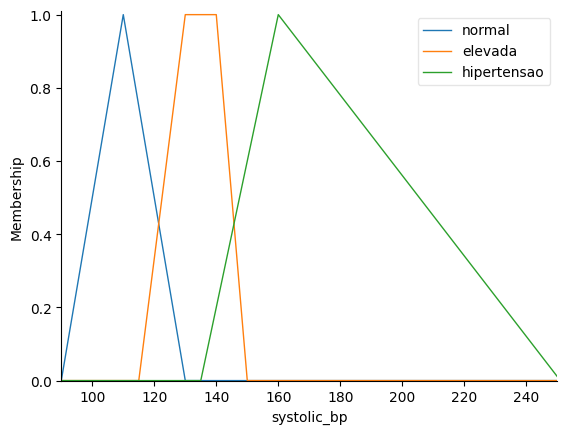

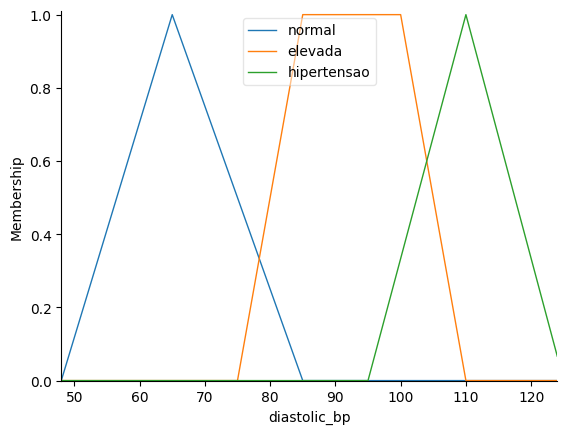

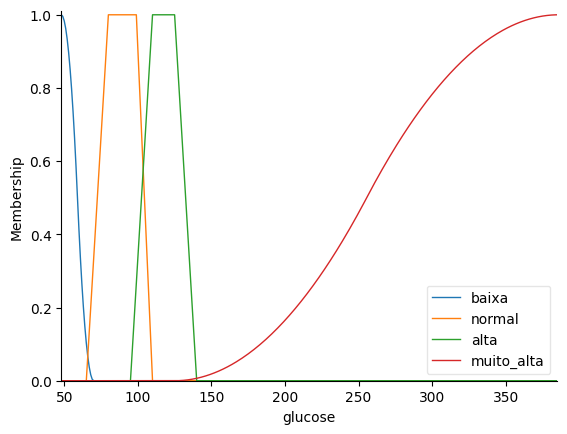

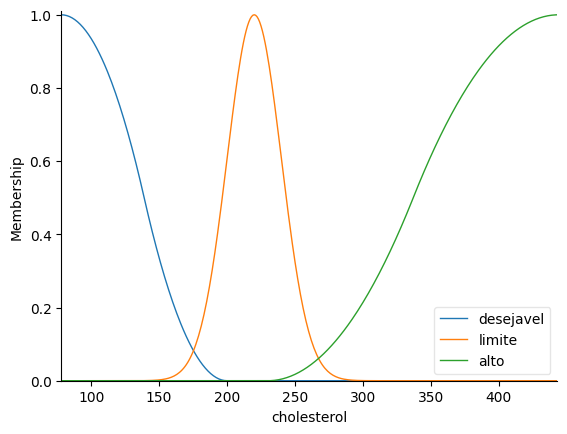

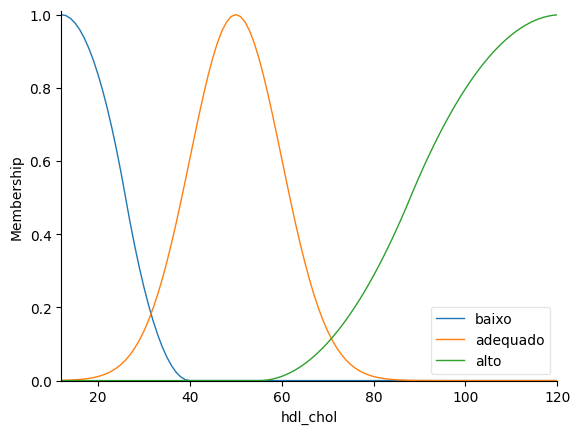

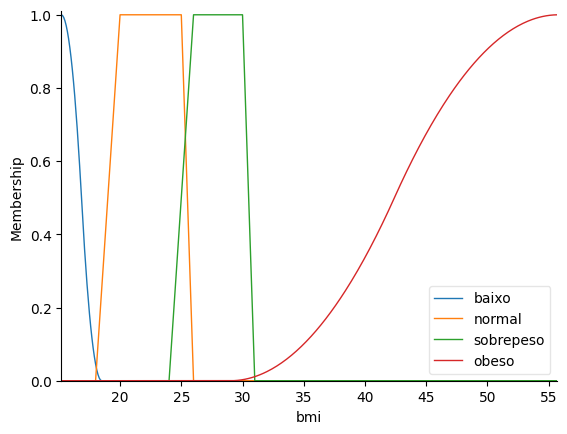

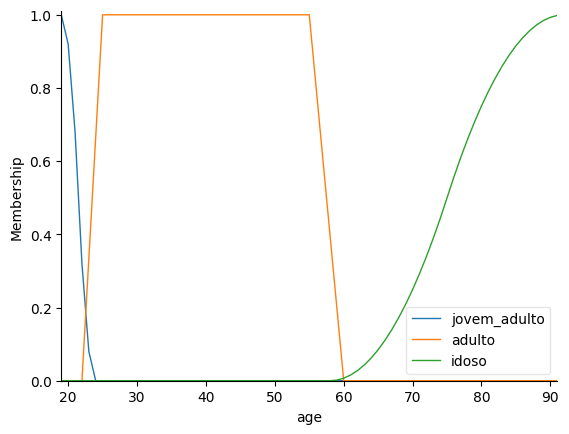

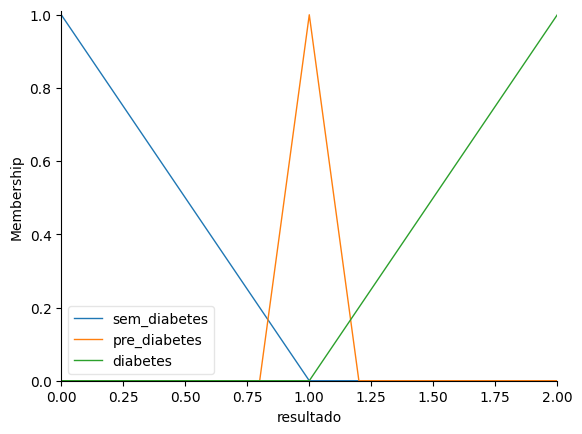

In [36]:
# VISUALIZANDO AS FUNÇÕES DE PERTINÊNCIA
systolic_bp.view()
diastolic_bp.view()
glucose.view()
cholesterol.view()
hdl_chol.view()
bmi.view()
age.view()
resultado.view()

### Rodando o Sistema

A partir do sistema criado, segue uma simulação de execução que recebe os dados pra cada variável e retorna uma pontuação (defuzzificação) no intervalo de 0 a 2, onde:

- 0: Sem Diabetes
- 1: Pré Diabético
- 2: Com Diabetes

Insira o valor da Pressão Sistólica:  120
Insira o valor da Pressão Diastólica:  80
Insira o valor da Glicose:  150
Insira o valor do Colesterol:  200
Insira o valor do HDL Colesterol:  30
Insira o valor do IMC:  29
Insira a Idade:  65




Resultado: 1.51


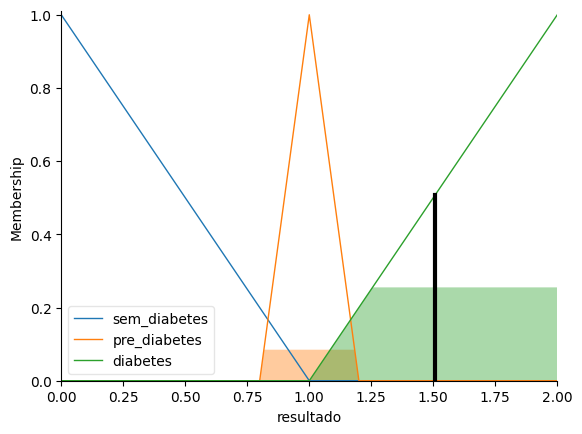

In [39]:
systolic_bp_input = float(input("Insira o valor da Pressão Sistólica: "))
diastolic_bp_input = float(input("Insira o valor da Pressão Diastólica: "))
glucose_input = float(input("Insira o valor da Glicose: "))
cholesterol_input = float(input("Insira o valor do Colesterol: "))
hdl_chol_input = float(input("Insira o valor do HDL Colesterol: "))
bmi_input = float(input("Insira o valor do IMC: "))
age_input = float(input("Insira a Idade: "))


diabetes_simulation.input['systolic_bp'] = systolic_bp_input
diabetes_simulation.input['diastolic_bp'] = diastolic_bp_input
diabetes_simulation.input['glucose'] = glucose_input
diabetes_simulation.input['cholesterol'] = cholesterol_input
diabetes_simulation.input['hdl_chol'] = hdl_chol_input
diabetes_simulation.input['bmi'] = bmi_input
diabetes_simulation.input['age'] = age_input


diabetes_simulation.compute()


print(f"\n\nResultado: {diabetes_simulation.output['resultado']:.2f}")
resultado.view(sim=diabetes_simulation)